In [2]:
using Plots
using Distributions
using Random, DataFrames
using LinearAlgebra
using MLJ, MLJLinearModels
using Hyperopt
using CSV
include("src/qsrfe.jl")
using .qsrfe

In [2]:
bX, bY = @load_boston
df = DataFrame(bX)
bX = Matrix(DataFrame(bX))
bY = collect(bY)
bX

bX = (bX .- mean(bX)) ./ std(bX)
Y = (bY .- mean(bY)) ./ std(bY)


In [4]:
df = CSV.read("./data/cancer_reg.csv", DataFrame)
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,avgAnnCount,606.339,6.0,171.0,38150.0,0,Float64
2,avgDeathsPerYear,185.966,3,61.0,14010,0,Int64
3,TARGET_deathRate,178.664,59.7,178.1,362.8,0,Float64
4,incidenceRate,448.269,201.3,453.549,1206.9,0,Float64
5,medIncome,47063.3,22640,45207.0,125635,0,Int64
6,popEst2015,1.02637e5,827,26643.0,10170292,0,Int64
7,povertyPercent,16.8782,3.2,15.9,47.4,0,Float64
8,studyPerCap,155.399,0.0,0.0,9762.31,0,Float64
9,binnedInc,,"(34218.1, 37413.8]",,"[22640, 34218.1]",0,String31


In [11]:
#y  = collect(df[:,1] .- mean(df[:,1])) ./ std(df[:,1])
function normalize!(x)
    return x = (x .- mean(x)) ./ std(x)
end
function normalizecols!(x)
    for i in 1:size(x,2)
        x[:,i] = normalize!(x[:,i])
    end
    return x
end
df = select!(df,Not([9,13]))
y  = convert.(Float64,collect(df[completecases(df),3]))
x = normalizecols!(Matrix(disallowmissing!(df[completecases(df),4:end])))
x

591×19 Matrix{Float64}:
 -0.755003    0.095935  -0.141337   …   0.536667    -0.952732   -0.740318
 -0.409296   -0.244614  -0.0766737     -0.164725    -0.047544   -0.597816
 -1.88591     0.256214  -0.206664      -0.421405     0.434123    0.556333
 -0.894757   -0.600069  -0.185792       0.107617    -0.37675     0.0786984
 -0.219892    0.267437   0.746288      -0.26174     -0.501521   -0.202017
  0.795165    1.2819     0.307292   …  -0.204902    -0.0711026  -0.294483
  0.193854    0.349769  -0.219114      -0.566517     0.330368   -2.73913
 -0.137143   -1.00112   -0.194008      -0.557705     0.636248   -1.81416
 -4.02084    -0.455485  -0.210917      -0.566517     0.417978    0.145694
 -1.7719     -0.525541  -0.203799      -0.534074     0.654249   -1.16384
  ⋮                                 ⋱                           
  0.0163923  -0.687135  -0.201913      -0.390695    -0.498124    1.56277
  0.0163923  -0.145974  -0.211647      -0.566517     0.707209    1.41024
  0.0163923  -0.693799  -0.

In [12]:
(xtrain, xtest), (ytrain, ytest) = partition((x, y), 0.8, rng=123, multi=true);

In [51]:
m = 1000

(xtrain, xtest), (ytrain, ytest) = (x[1:463715,:], x[463716:end,:]), (y[1:463715], y[463716:end])
shuffleorder = shuffle(1:size(xtrain,1))[1:m]
xtrain, ytrain = xtrain[shuffleorder, :], ytrain[shuffleorder]

([0.2382205919647473 0.4892022606305371 … 0.21466205907183722 0.23319435793078985; 0.7288480129676733 -0.4433356089600435 … 0.39289719874643103 -0.516113958117502; … ; -0.2853624303508632 -0.6048778051488959 … -1.2131978422036718 -1.6075884034148749; -1.1261241620396585 -2.7669245258536863 … 0.7174083238705339 -0.8393182680454313], [1982.0, 1994.0, 1999.0, 1956.0, 2009.0, 2004.0, 1998.0, 2005.0, 1982.0, 2009.0  …  2005.0, 2008.0, 1984.0, 1996.0, 2001.0, 2008.0, 2009.0, 1979.0, 1997.0, 2008.0])

In [40]:
model = qsrfe.srfeRegressor(N=8000,λ=1.0,q=0,intercept=true)
c, ω, ζ = qsrfe.fit(model,xtrain,ytrain;verbose=true)
ypred = qsrfe.predict(model,xtest,c, ω, ζ)
ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ)
qsrfe.test_metrics(ytest,ypred,ytrain,ytrainpred)

support: 212/8001

MSE: 476.24713260444116 train MSE: 193.12884936210756
rel: 0.09165357556139166 train rel: 0.06093206746685244


In [47]:
model = qsrfe.srfeRegressor(N=16384,λ=0.03,intercept=false)
#quantizer = qsrfe.MSQ(K=2)
#quantizer = qsrfe.ΣΔQ(K=2,r=1,λ=2,condense=false)
quantizer = qsrfe.βQ(K=2,β=1.5,λ=16,condense=true)
c, ω, ζ = qsrfe.fit(model,xtrain,ytrain,quantizer;verbose=true)
ypred = qsrfe.predict(model,xtest,c, ω, ζ, quantizer)
ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ,quantizer)
qsrfe.test_metrics(ytest,ypred,ytrain,ytrainpred)

support: 380/1024

MSE: 18556.747157828675 train MSE: 750.0269401734795
rel: 0.5891968307335639 train rel: 0.12360512049341912


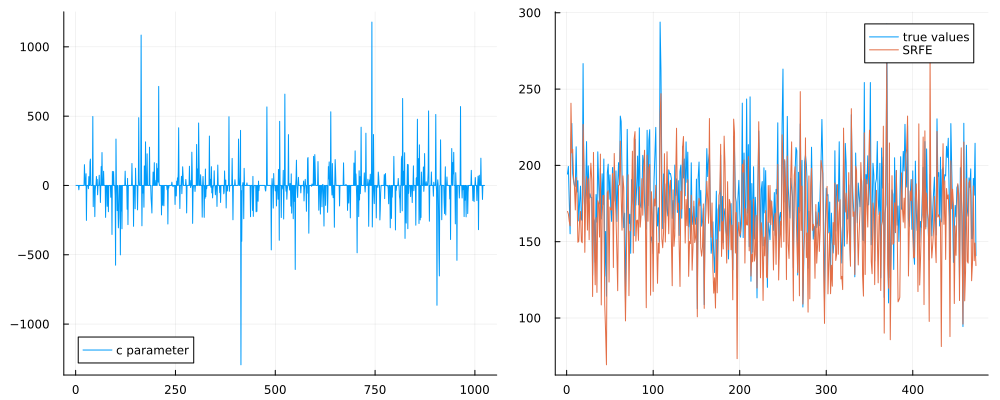

In [48]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[1:end], label="true values")
plot!(ytrainpred[1:end], label="SRFE")
plot(p1,p2,layout=2,size=(1000,400))


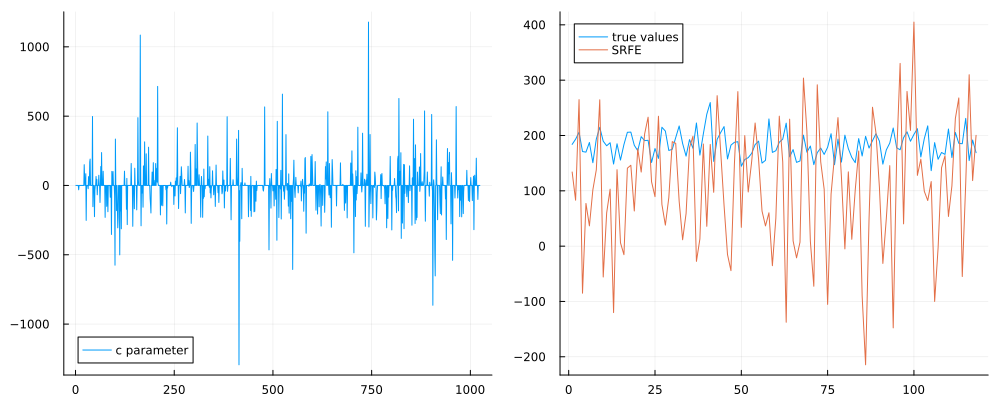

In [49]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytest[1:end], label="true values")
plot!(ypred[1:end], label="SRFE")
plot(p1,p2,layout=2,size=(1000,400))